In [90]:
library(gtools)
library(dplyr)
library(ggplot2)

In [91]:
# load data
inTeams<-read.csv("https://projects.fivethirtyeight.com/soccer-api/club/spi_global_rankings.csv")

In [4]:
# PRE SIMULATION WORK

In [92]:
# Prize dataframe
ranks <- 1:20
prizes <- matrix(ranks, nrow=20, ncol=1, byrow=FALSE)
prizes <- as.data.frame(prizes)
colnames(prizes) <- c('team_rank')
prizes$prize <- c(225,210,200,190,160,150,140,125,123,120,118,115,112,110,108,105,100,52,50,49)

In [93]:
# taking averages
mean.off<-mean(inTeams$off)
mean.def<-mean(inTeams$def)
lmean.off<-mean(log(inTeams$off))
lmean.def<-mean(log(inTeams$def)) 

# subset to premier league
premLeague<-subset(inTeams,league=="Barclays Premier League")
premTeams<-premLeague$name
rownames(premLeague)<-premTeams
df.prem<-premLeague[,c("off","def")]

# build parameters
lmean.def<- log(mean(df.prem$def))
lmean.off<- log(mean(df.prem$off))               
df.prem["alpha"]<-log(df.prem["off"])-lmean.def
df.prem["delta"]<-lmean.off-log(df.prem["def"])
alphaList<-df.prem$alpha
deltaList<-df.prem$delta
names(alphaList)<-rownames(df.prem)
names(deltaList)<-rownames(df.prem)

In [94]:
df.prem

,off,def,alpha,delta
,<dbl>,<dbl>,<dbl>,<dbl>
Manchester City,2.90,0.20,1.3835395,2.3108012
Liverpool,2.92,0.25,1.3904124,2.0876577
Chelsea,2.39,0.29,1.1901222,1.9392377
Arsenal,2.16,0.46,1.0889370,1.4778921
Tottenham Hotspur,2.36,0.65,1.1774904,1.1321463
Manchester United,2.19,0.67,1.1027303,1.1018409
Aston Villa,1.99,0.63,1.0069634,1.1633988
West Ham United,2.02,0.73,1.0219263,1.0160741
Brighton and Hove Albion,1.85,0.62,0.9340144,1.1793991


In [95]:
# simulate score line for a match
draw.score<-function(team1,team2){
    c(
        rpois(1,exp(alphaList[team1]-deltaList[team2])),
  rpois(1,exp(alphaList[team2]-deltaList[team1]))
    )
}
draw.score("Liverpool","Arsenal")

[1] 2 1

In [96]:
# All possible matches in a season
allMatches<-permutations(20, 2, v=rownames(df.prem),repeats.allowed=FALSE)
colnames(allMatches)<-c("home","away")
allMatches
nrow(allMatches)

home,away
Arsenal,Aston Villa
Arsenal,Brentford
Arsenal,Brighton and Hove Albion
Arsenal,Burnley
Arsenal,Chelsea
Arsenal,Crystal Palace
Arsenal,Everton
Arsenal,Leeds United
Arsenal,Leicester City
Arsenal,Liverpool


[1] 380

In [9]:
# SIMULATION

In [97]:
SeasonSim <- function(allMatches){
     ScoresMatrix <- matrix(nrow=nrow(allMatches),  ncol=4)
        for (ii in 1:nrow(allMatches)  ) {
         ScoresMatrix[ii,1:2]=allMatches[ii,]
         ScoresMatrix[ii,3:4]= as.numeric(draw.score(allMatches[ii,"home"],allMatches[ii,"away"] ))
        }
        colnames(ScoresMatrix)<-c("home.team","away.team","home.score","away.score")
        ScoresMatrix <- as.data.frame(ScoresMatrix)
        ScoresMatrix$home.score <- as.numeric(ScoresMatrix$home.score)
        ScoresMatrix$away.score <- as.numeric(ScoresMatrix$away.score)  
        
        # PEPARING AGGREGATE STATS DFs
        df.points <- as.data.frame(ScoresMatrix)
        df.points_goalsfor <- as.data.frame(ScoresMatrix)
        df.points_goalsagainst <- as.data.frame(ScoresMatrix)
        name <- rownames(df.prem)
        for (i in 1:20){
            df.points[, name[i]] <- 0
        }
        df.points

        # ASSIGNING POINTS PER MATCH
        for (i in 1:380){ 
            for (j in 1:20){
                if (df.points[i,1] == name[j]){
                    if (df.points[i,3] > df.points[i,4]){
                        df.points[i,j+4] = 3
                    } else if (df.points[i,3] == df.points[i,4]){
                        df.points[i,j+4] = 1
                    } else if (df.points[i,3] < df.points[i,4]){
                        df.points[i,j+4] = 0
                    } 
                } 
                if (df.points[i,2] == name[j]){
                    if (df.points[i,3] > df.points[i,4]){
                        df.points[i,j+4] = 0
                    } else if (df.points[i,3] == df.points[i,4]){
                        df.points[i,j+4] = 1
                    } else if (df.points[i,3] < df.points[i,4]){
                        df.points[i,j+4] = 3
                    }      
                }
            }   
        } 
    
        # PREPARING DFs
        for (i in 1:20){
            df.points_goalsfor[, name[i]] <- 0
        }
        for (i in 1:20){
            df.points_goalsagainst[, name[i]] <- 0
        }
    
        # GOALS FOR
        for (i in 1:380){
            for (j in 1:20){
                if (df.points_goalsfor[i,1] == name[j]){ # looking at home team
                    df.points_goalsfor[i,j+4] = df.points_goalsfor[i,3]  # home points go to goals for
                }
                if (df.points_goalsfor[i,2] == name[j]){ # looking at away team
                    df.points_goalsfor[i,j+4] = df.points_goalsfor[i,4] # away points go to goals for
                }
            }
        }
    
        # GOALS AGAINST
        for (i in 1:380){
            for (j in 1:20){
                if (df.points_goalsagainst[i,1] == name[j]){ # looking at home team
                    df.points_goalsagainst[i,j+4] = df.points_goalsagainst[i,4]  # home points go to goals for
                }
                if (df.points_goalsagainst[i,2] == name[j]){ # looking at away team
                    df.points_goalsagainst[i,j+4] = df.points_goalsagainst[i,3] # away points go to goals for
                }
            }
        } 
        
        # AGGREGATING POINTS and GOALS
        points <- df.points[,c(-1,-2,-3,-4)]
        points <- sapply(points, as.numeric)
        points_sum <- as.data.frame(colSums(points))
        
        goalsfor <- df.points_goalsfor[,c(-1,-2,-3,-4)]
        goalsfor <- sapply(goalsfor, as.numeric)
        goalsfor_sum <- as.data.frame(colSums(goalsfor))
    
        goalsagainst <- df.points_goalsagainst[,c(-1,-2,-3,-4)]
        goalsagainst <- sapply(goalsagainst, as.numeric)
        goalsagainst_sum <- as.data.frame(colSums(goalsagainst))

        # MERGE TO ONE DF
        df.teams <- cbind(points_sum, goalsfor_sum, goalsagainst_sum)
        colnames(df.teams)[1] <- 'points'
        colnames(df.teams)[2] <- 'goals_for'
        colnames(df.teams)[3] <- 'goals_against'
        df.teams$team_names <- row.names(df.teams)
    
        # ADD TIE BREAKER VARIABLES
        df.teams <- df.teams %>%
            mutate(net_goals = goals_for - goals_against) %>%
            mutate(tie_breaker = runif(20, 0, 1))
        df.teams1 <- df.teams
        df.teams1$temp_team_rank <- rank(desc(df.teams1$points))
        df.teams1$temp_team_rank2 <- rank(desc(df.teams1$points))
        df.teams1$goals_rank <- rank(desc(df.teams1$net_goals))
        df.teams1$goalsfor_rank <- rank(desc(df.teams1$goals_for))
        df.teams1
    
        # RANK 
        for (ii in 1:nrow(df.teams1)){
            for (jj in 1:nrow(df.teams1)){
                if (ii != jj & df.teams1[ii,7] == df.teams1[jj,7]){
                    if (df.teams1[ii,9] > df.teams1[jj,9]){ #goals rank
                        df.teams1[ii,8] = df.teams1[ii,8]+0.5
                        df.teams1[jj,8] = df.teams1[jj,8]-0.5
                    } else if (df.teams1[ii,9] == df.teams1[jj,9]){ 
                        if (df.teams1[ii,10] > df.teams1[jj,10]){ #goals_for rank
                            df.teams1[ii,8] = df.teams1[ii,8]+0.5
                            df.teams1[jj,8] = df.teams1[jj,8]-0.5
                        } else if (df.teams1[ii,10] == df.teams1[jj,10]){                   
                            if (df.teams1[ii,6] > df.teams1[jj,6]){
                            df.teams1[ii,8] = df.teams1[ii,8]+0.5
                            df.teams1[jj,8] = df.teams1[jj,8]-0.5
                            }   
                        }
                    }
                }
            }
        }
        df.teams1$team_rank <- rank(df.teams1$temp_team_rank2)
        
         # ASSIGN PRIZE
        df.earnings <- left_join(df.teams1, prizes, by=c("team_rank"))
        df.earnings
    }

SeasonSim(allMatches)

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
80,51,10,Manchester City,41,0.24993774,1.0,1,1.0,1.5,1,225
76,51,16,Liverpool,35,0.10331808,2.0,2,2.0,1.5,2,210
75,36,14,Chelsea,22,0.62802481,3.5,4,4.0,11.5,4,190
65,37,18,Arsenal,19,0.60424046,5.0,5,5.0,9.5,5,160
57,41,27,Tottenham Hotspur,14,0.23612120,8.0,8,6.5,6.0,8,125
56,40,29,Manchester United,11,0.97397612,9.0,9,8.0,7.5,9,123
75,48,19,Aston Villa,29,0.06575056,3.5,3,3.0,3.0,3,200
43,31,32,West Ham United,-1,0.90952238,13.0,13,12.0,17.0,13,112
49,37,37,Brighton and Hove Albion,0,0.55701514,12.0,12,10.5,9.5,12,115


In [129]:
# results df
df.final.output <- data.frame(matrix(ncol = 0, nrow = 0))

# simulations
nsims <- 100

# simulation
for (rep in 1:nsims) {
    df.sim.earnings <- SeasonSim(allMatches)
    df.sim.earnings$sim <- rep
    df.final.output <- rbind(df.final.output, df.sim.earnings)
}

df.final.output

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,sim
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
101,87,7,Manchester City,80,0.17482525,1.0,1,1.0,1.0,1,225,1
84,55,11,Liverpool,44,0.22705789,2.0,2,2.0,2.0,2,210,1
79,47,17,Chelsea,30,0.89445943,3.0,3,3.0,3.5,3,200,1
69,43,21,Arsenal,22,0.25212623,4.0,4,4.0,5.0,4,190,1
52,47,47,Tottenham Hotspur,0,0.52235602,9.0,9,8.0,3.5,9,123,1
56,42,32,Manchester United,10,0.78324457,7.0,7,6.0,6.0,7,140,1
53,40,48,Aston Villa,-8,0.44821126,8.0,8,10.0,9.0,8,125,1
58,40,41,West Ham United,-1,0.22043026,6.0,6,9.0,9.0,6,150,1
46,40,37,Brighton and Hove Albion,3,0.45866290,10.0,10,7.0,9.0,10,120,1


In [132]:
# write.csv(df.final.output, "C:\\Users\\Kiersten\\Documents\\simulation.csv")

write.csv(df.final.output, "simulation.csv")

***ANALYSIS***
1. Assemble a ranking of the teams from best to worst according to their expected position in the table.
    Illustrate this ranking with a clear visualization
2. Which teams have the most variability in their simulated earnings?
    Again, illustrate this variability with a clear visualization.
3. Which teams stand to benefit the most in monetary terms from a "lucky win" (converting one of their losses to a win)?
    Again provide a visualization of this marginal effect
4. Finally, for each team, calculate the monetary benefit to each team from either (i) an increase of 10% to their expected goals scored (holding everyone else constant), or (ii) a decreasing in their expected goals conceded by 10% (Note that this means 40 separate simulations!)
    Use this to provide a clear visualization of the benefits of investing in offense versus defense by team

***1. Teams by best to worst expected position***

In [99]:
head(df.final.output)
# taking averages
df.summary <- df.final.output %>%
    group_by(team_names) %>%
    mutate(avg_rank = mean(team_rank)) %>%
    mutate(avg_prize = mean(prize)) %>%
    mutate(variability = sd(team_rank)) # sqrt of the variance


df.analysis <- select(df.summary, c(4,14,15,16))
df.analysis = unique(df.analysis)
df.analysis

,points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,sim
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,83,65,12,Manchester City,53,0.6461407,1.0,1,2,2.0,1,225,1
2,80,69,15,Liverpool,54,0.3805198,2.0,2,1,1.0,2,210,1
3,67,46,14,Chelsea,32,0.5009654,3.5,3,3,3.0,3,200,1
4,67,43,24,Arsenal,19,0.5901715,3.5,4,4,4.5,4,190,1
5,61,40,32,Tottenham Hotspur,8,0.9913548,6.0,6,6,8.0,6,150,1
6,56,32,29,Manchester United,3,0.5578371,8.0,8,8,14.0,8,125,1


team_names,avg_rank,avg_prize,variability
<chr>,<dbl>,<dbl>,<dbl>
Manchester City,1.40,219.35,0.6195469
Liverpool,1.92,212.15,0.7061061
Chelsea,3.05,198.80,0.9885711
Arsenal,5.06,170.97,2.0091709
Tottenham Hotspur,6.46,151.43,2.3588218
Manchester United,7.80,140.18,3.1782086
Aston Villa,8.34,135.46,3.1437609
West Ham United,9.70,126.93,3.4126917
Brighton and Hove Albion,9.12,129.05,3.0953859


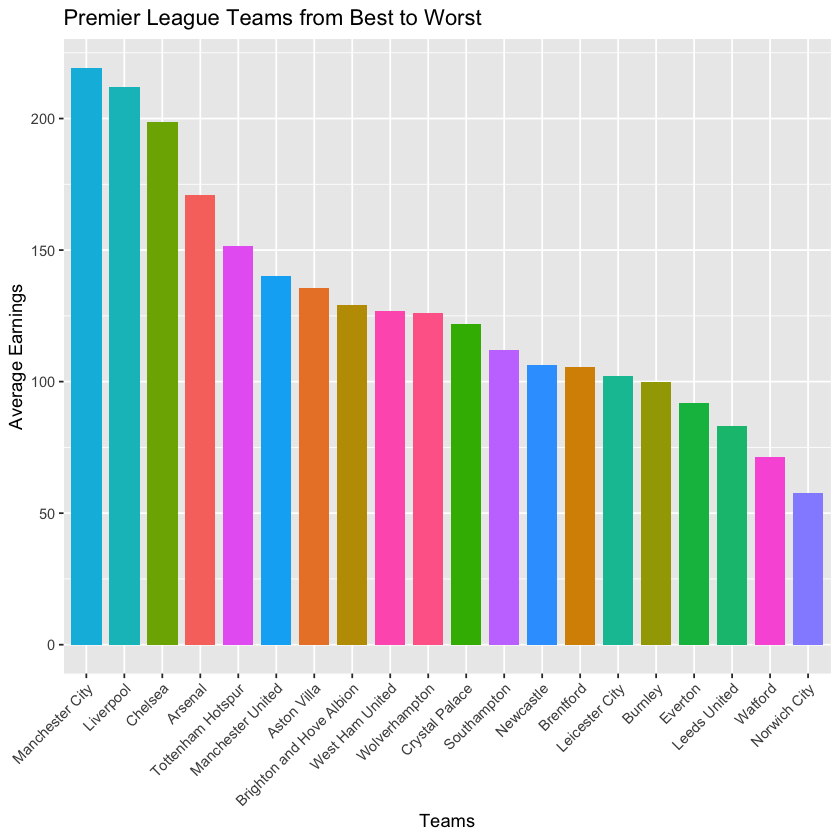

In [100]:
# Visualize rankings/earnings
ggplot(df.analysis, aes(x=reorder(team_names,-avg_prize), y=avg_prize, fill=team_names)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Average Earnings') +
  ggtitle('Premier League Teams from Best to Worst') +
  theme(legend.position="none")

***2. Which teams have the most variability in their simulated earnings?***
South Hampton, West Ham United, Brentford (based off of sensitive measure of variability)

Visualizing the range of earnings per team:
Resistance measure (interquartile range)

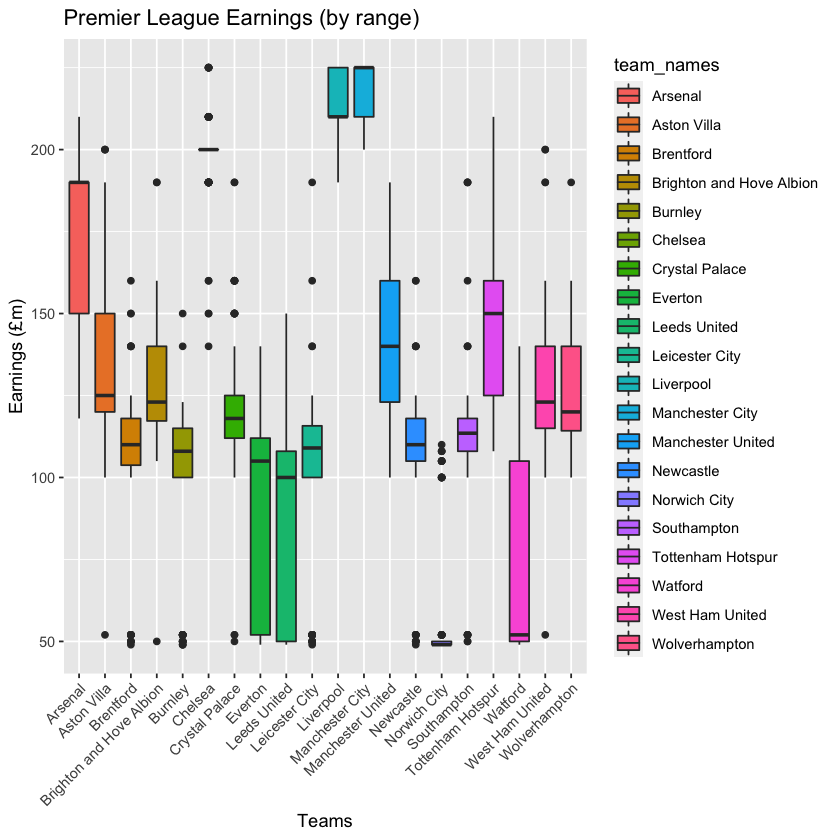

In [101]:
ggplot(df.summary, aes(x=team_names, y=prize, fill=team_names)) +
    geom_boxplot() +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    xlab('Teams') +
    ylab('Earnings (£m)') +
    ggtitle('Premier League Earnings (by range)')

Standard deviation (sensitive measure):
Use given we won't have extreme outliers since our model doesn't account for shocks

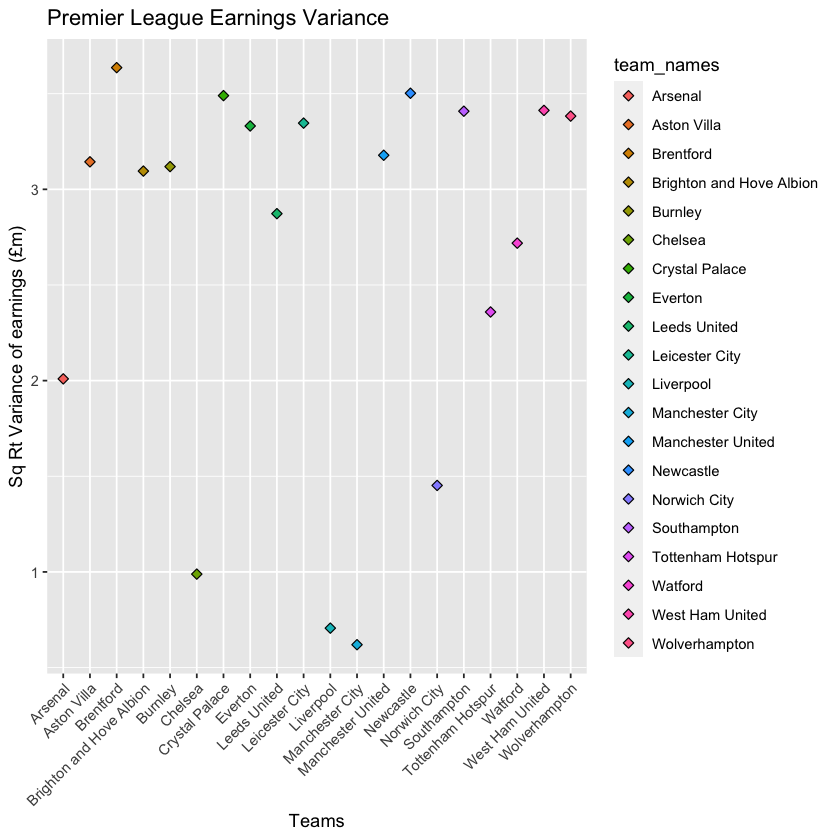

In [102]:
ggplot(df.analysis, aes(x=team_names, y=variability, fill=team_names)) +
  geom_point(size=2, shape=23) +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    xlab('Teams') +
    ylab('Sq Rt Variance of earnings (£m)') +
    ggtitle('Premier League Earnings Variance')

***3. Which teams stand to benefit the most in monetary terms from a "lucky win" (converting one of their losses to a win)? (visualization of marginal effect)***

In [103]:
# clean appropriate variables
df.summary$prize <- as.numeric(df.summary$prize)
df.summary$points <- as.numeric(df.summary$points)
df.summary$goals_for <- as.numeric(df.summary$goals_for)
df.summary$goals_against <- as.numeric(df.summary$goals_against)
df.summary$net_goals <- as.numeric(df.summary$net_goals)
df.summary$tie_breaker <- as.numeric(df.summary$tie_breaker)
df.summary$team.f <- factor(df.summary$team_names)

reg1 <- lm(prize ~ points + team.f + team.f*points, data=df.summary) 
summary(reg1)


Call:
lm(formula = prize ~ points + team.f + team.f * points, data = df.summary)

Residuals:
    Min      1Q  Median      3Q     Max 
-44.397  -7.393   0.159   7.441  42.515 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           -22.67788   10.98823  -2.064  0.03916 *  
points                                  2.98978    0.16848  17.746  < 2e-16 ***
team.fAston Villa                      -1.74489   14.72550  -0.118  0.90569    
team.fBrentford                        16.89274   13.29967   1.270  0.20418    
team.fBrighton and Hove Albion         20.37364   14.93484   1.364  0.17267    
team.fBurnley                          10.52269   13.18679   0.798  0.42498    
team.fChelsea                         110.16591   18.47312   5.964 2.92e-09 ***
team.fCrystal Palace                   26.89643   13.74222   1.957  0.05046 .  
team.fEverton                         -11.50531   12.88037  -0.893  0.37184    
team.fLee

In [104]:
points1 <- rep(3, 20)
newdata1 <- data.frame(points1)
names(newdata1)[names(newdata1) == 'points1'] <- 'points'
newdata1$team.f <- df.summary$team.f[1:20]
newdata1$prize <- predict(reg1, newdata1)

points2 <- rep(0, 20)
newdata2 <- data.frame(points2)
names(newdata2)[names(newdata2) == 'points2'] <- 'points'
newdata2$team.f <- df.summary$team.f[1:20]
newdata2$prize <- predict(reg1, newdata2)

newdata1$prize_change <- newdata1$prize - newdata2$prize

newdata1

points,team.f,prize,prize_change
<dbl>,<fct>,<dbl>,<dbl>
3,Manchester City,145.498856,2.672538
3,Liverpool,126.584575,3.243162
3,Chelsea,91.955397,4.467370
3,Arsenal,-13.708547,8.969332
3,Tottenham Hotspur,-29.890973,9.732741
3,Manchester United,5.715420,7.663255
3,Aston Villa,-15.592721,8.830050
3,West Ham United,4.208736,7.538161
3,Brighton and Hove Albion,5.184600,7.488839


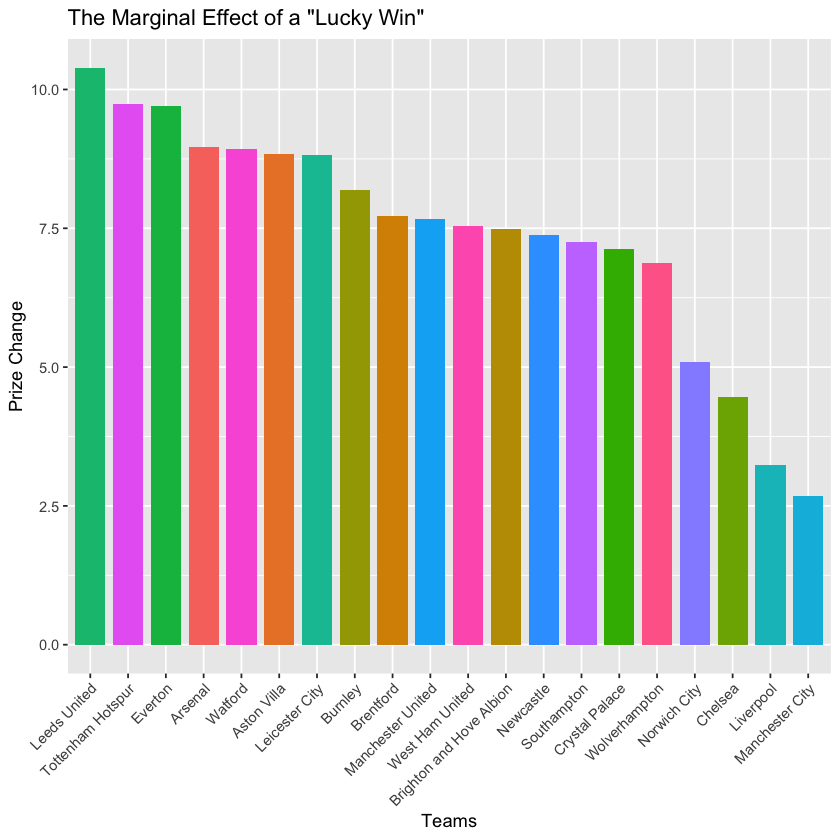

In [105]:
ggplot(newdata1, aes(x=reorder(team.f,-prize_change), y=prize_change, fill=team.f)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Prize Change') +
  ggtitle('The Marginal Effect of a "Lucky Win"') +
  theme(legend.position="none")

In [106]:
# # plot (not right code, just a template)
# ggplot(dummy, aes(x=x, y=predicted)) +
#   geom_bar(stat = "identity", position = position_dodge()) +
#   geom_errorbar(aes(ymin = conf.low, ymax = conf.high), alpha = .9,position = position_dodge())+
#   labs(
#     x="Sex",
#     y="Salary",
#     title="The Marginal Effect of Sex on Salary"
#   )+scale_x_continuous(breaks=c(1,2) ,labels = c("Female", "Male"))

***4. Finally, for each team, calculate the monetary benefit to each team from either 
    (i) an increase of 10% to their expected goals scored (holding everyone else constant), or 
    (ii) a decreasing in their expected goals conceded by 10% (Note that this means 40 separate simulations!)***
    
    Use this to provide a clear visualization of the benefits of investing in offense versus defense by team

In [137]:
# an increase of 10% to the expected goals scored
df.offense <- data.frame(matrix(ncol = 0, nrow = 0))

for (i in 1:20) {
    # increasing goals scored by 10%
    df.prem[i,1] = df.prem[i,1]*1.1

    # build parameters
    lmean.def<- log(mean(df.prem$def))
    lmean.off<- log(mean(df.prem$off))               
    df.prem["alpha"]<-log(df.prem["off"])-lmean.def
    df.prem["delta"]<-lmean.off-log(df.prem["def"])
    alphaList<-df.prem$alpha
    deltaList<-df.prem$delta
    names(alphaList)<-rownames(df.prem)
    names(deltaList)<-rownames(df.prem)

    # simulation (with one team changed)
    df.sim.earnings <- SeasonSim(allMatches)
    df.sim.earnings$team_change <- rownames(df.prem)[i]
    df.offense <- rbind(df.offense, df.sim.earnings)
}

head(df.offense)

,points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,team_change
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,110,123,7,Manchester City,116,0.7756008,1.0,1,1.0,1.0,1,225,Manchester City
2,73,40,9,Liverpool,31,0.8945137,2.0,2,2.0,3.5,2,210,Manchester City
3,67,40,21,Chelsea,19,0.9592433,3.5,3,3.0,3.5,3,200,Manchester City
4,61,29,18,Arsenal,11,0.6514620,6.5,6,4.5,15.0,6,150,Manchester City
5,60,34,30,Tottenham Hotspur,4,0.6923776,8.0,8,8.0,10.0,8,125,Manchester City
6,61,36,33,Manchester United,3,0.6041421,6.5,7,9.0,6.5,7,140,Manchester City


In [139]:
# a decreasing in the expected goals conceded by 10%
df.defense <- data.frame(matrix(ncol = 0, nrow = 0))

for (i in 1:20) {
    # decreasing goals conceded by 10%
    df.prem[i,2] = df.prem[i,2]*.9

    # build parameters
    lmean.def<- log(mean(df.prem$def))
    lmean.off<- log(mean(df.prem$off))               
    df.prem["alpha"]<-log(df.prem["off"])-lmean.def
    df.prem["delta"]<-lmean.off-log(df.prem["def"])
    alphaList<-df.prem$alpha
    deltaList<-df.prem$delta
    names(alphaList)<-rownames(df.prem)
    names(deltaList)<-rownames(df.prem)

    # simulation (with one team changed)
    df.sim.earnings <- SeasonSim(allMatches)
    df.sim.earnings$team_change <- rownames(df.prem)[i]
    df.defense <- rbind(df.defense, df.sim.earnings)
}

head(df.defense)

,points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,team_change
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,104,104,5,Manchester City,99,0.29583171,1.0,1,1,1,1,225,Manchester City
2,89,66,20,Liverpool,46,0.09318637,2.0,2,2,2,2,210,Manchester City
3,76,60,16,Chelsea,44,0.40426541,3.0,3,3,3,3,200,Manchester City
4,63,38,19,Arsenal,19,0.10089327,5.0,5,4,8,5,160,Manchester City
5,50,33,32,Tottenham Hotspur,1,0.38674956,9.5,9,9,10,9,123,Manchester City
6,58,46,34,Manchester United,12,0.33835478,7.0,6,6,5,6,150,Manchester City


In [148]:
offense <- data.frame(matrix(ncol = 0, nrow = 0))
defense <- data.frame(matrix(ncol = 0, nrow = 0))

for (i in 1:400){
    if (df.offense[i, 4] == df.offense[i, 13]){
        offense <- rbind(offense, df.offense[i,])
    }
    if (df.defense[i, 4] == df.defense[i, 13]){
        defense <- rbind(defense, df.defense[i,])
    }
}

offense
defense

,points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,team_change
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,110,123,7,Manchester City,116,0.77560080,1.0,1,1.0,1.0,1,225,Manchester City
22,77,62,14,Liverpool,48,0.07548493,2.0,2,2.0,2.0,2,210,Liverpool
43,81,55,12,Chelsea,43,0.52800276,3.0,3,3.0,3.0,3,200,Chelsea
64,64,48,28,Arsenal,20,0.51163663,5.0,5,4.0,3.0,5,160,Arsenal
85,65,46,28,Tottenham Hotspur,18,0.86730103,5.0,5,5.0,5.0,5,160,Tottenham Hotspur
106,52,40,37,Manchester United,3,0.39700192,9.5,9,6.0,6.0,9,123,Manchester United
127,67,40,24,Aston Villa,16,0.43704524,5.5,6,6.0,5.0,6,150,Aston Villa
148,59,44,34,West Ham United,10,0.35914888,8.0,8,7.0,5.0,8,125,West Ham United
169,49,34,30,Brighton and Hove Albion,4,0.92178053,10.0,10,9.0,10.0,10,120,Brighton and Hove Albion


,points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,team_change
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,104,104,5,Manchester City,99,0.2958317,1.0,1,1.0,1.0,1,225,Manchester City
22,88,64,13,Liverpool,51,0.3785759,2.0,2,2.0,2.0,2,210,Liverpool
43,71,41,14,Chelsea,27,0.2504069,3.0,3,3.0,4.0,3,200,Chelsea
64,75,47,23,Arsenal,24,0.4049943,4.0,4,4.0,6.0,4,190,Arsenal
85,57,43,35,Tottenham Hotspur,8,0.8600901,6.0,6,5.0,5.5,6,150,Tottenham Hotspur
106,63,37,27,Manchester United,10,0.7380686,6.0,6,7.0,10.0,6,150,Manchester United
127,55,36,26,Aston Villa,10,0.6310545,8.5,8,4.5,9.5,8,125,Aston Villa
148,62,45,33,West Ham United,12,0.8209515,6.5,6,7.0,4.0,6,150,West Ham United
169,51,30,30,Brighton and Hove Albion,0,0.8447686,9.0,9,9.0,13.5,9,123,Brighton and Hove Albion


In [156]:
df.change <- df.analysis
df.change$inc_change <- offense$prize
df.change$dec_change <- defense$prize
df.change$inc_change_diff <- df.change$inc_change - df.change$avg_prize
df.change$dec_change_diff <- df.change$dec_change - df.change$avg_prize

df.change

team_names,avg_rank,avg_prize,variability,inc_change,dec_change,inc_change_diff,dec_change_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Manchester City,1.40,219.35,0.6195469,225,225,5.65,5.65
Liverpool,1.92,212.15,0.7061061,210,210,-2.15,-2.15
Chelsea,3.05,198.80,0.9885711,200,200,1.20,1.20
Arsenal,5.06,170.97,2.0091709,160,190,-10.97,19.03
Tottenham Hotspur,6.46,151.43,2.3588218,160,150,8.57,-1.43
Manchester United,7.80,140.18,3.1782086,123,150,-17.18,9.82
Aston Villa,8.34,135.46,3.1437609,150,125,14.54,-10.46
West Ham United,9.70,126.93,3.4126917,125,150,-1.93,23.07
Brighton and Hove Albion,9.12,129.05,3.0953859,120,123,-9.05,-6.05


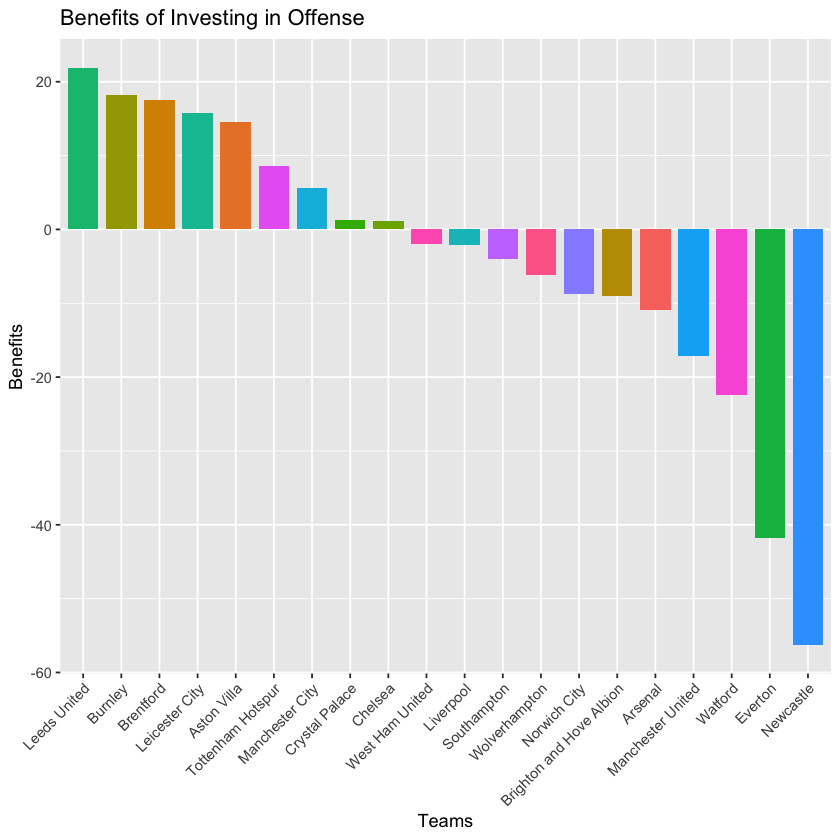

In [159]:
ggplot(df.change, aes(x=reorder(team_names,-inc_change_diff), y=inc_change_diff, fill=team_names)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Benefits') +
  ggtitle('Benefits of Investing in Offense') +
  theme(legend.position="none")

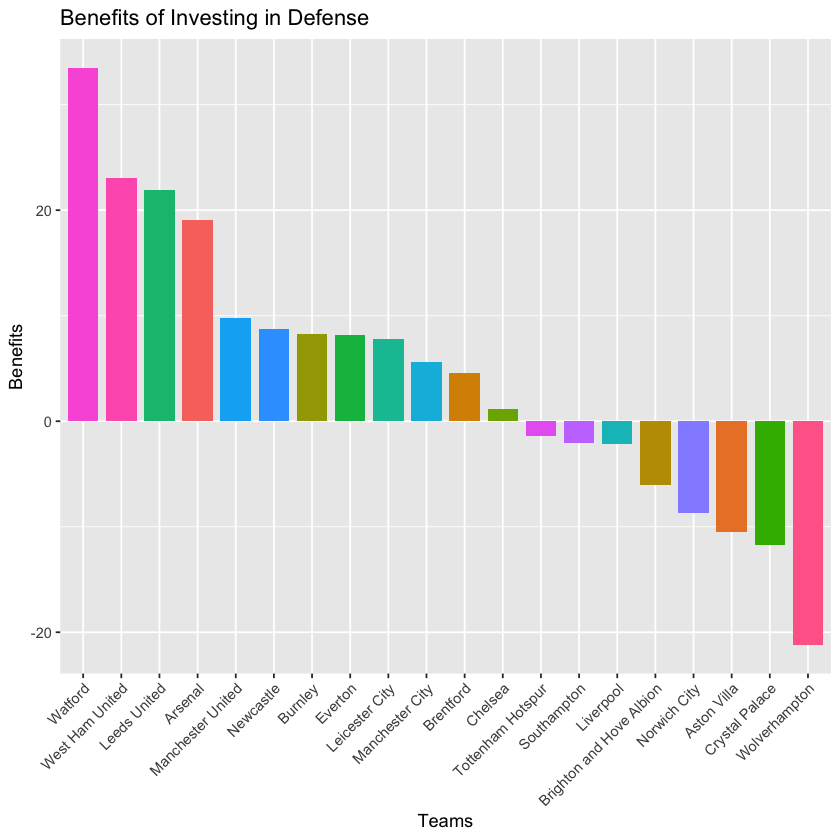

In [160]:
ggplot(df.change, aes(x=reorder(team_names,-dec_change_diff), y=dec_change_diff, fill=team_names)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Benefits') +
  ggtitle('Benefits of Investing in Defense') +
  theme(legend.position="none")